In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

### Create a function that plots the distribution of the digits of a given array compared to the distribution of Benford's law

In [166]:
# distribution according to Benford's law
benford = np.array([30.1, 17.6,12.5,9.7,7.9,6.7,5.8,5.1,4.6])


# this function returns perc, RMSE, where 
# perc is an array of length 9 with at i-th position the percentage of the i-th digit (starting from 1)
# RMSE is the error measuring how far perc is from benford
def Benford(w):
    
    # if a list is given, turn it into an numpy array
    if type(w) is not np.ndarray: w = w.to_numpy()
        
    # extract the first non zero digit
    for j in range(len(w)):
        # if the number is zero, skip
        if w[j]==0: continue
        u = str(w[j])
        # until there are zeros, skip to the next digit
        while (u[0]=='0') or (u[0]=='.'): # skip also '.' in case the number is 0.04274 for example
            u = u[1:]
        
        w[j]=int(u[0])
    
    # now w is an array with integers from 0. to 9.
    
    # count the frequency of each digit as percentage 
    count = pd.Series(w).value_counts(normalize=True).sort_index()
    
    # it might be that a digit is missing. put zero instead.
    perc = pd.DataFrame(count)
    perc.index= [int(x) for x in perc.index]
    zeros = pd.DataFrame({'zero': np.zeros(10)},np.arange(0,10))
    join_df = perc.join(zeros,how='outer').fillna(0)
    
    perc = list((join_df[0]+join_df['zero'])*100)[1:10] # EXCLUDE ZERO!
      
    # calculate root mean squared error
    RMSE = mean_squared_error(benford,perc, squared= False)/(benford.max()-benford.min())
    
    return perc, RMSE

# this function plots the two percentage vectors. Can put the name of the given vector as input
def Benford_print(w, name= 'Given'):
    perc, RMSE = Benford(w)
    
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xticks(np.arange(1,10))
    plt.scatter(np.arange(1,10), perc, label = 'Naive')
    plt.scatter(np.arange(1,10), benford, color = 'r', label = 'Benford')
    plt.title('Comparing '+name+' and Benford distributions')
    plt.ylabel('Percentage')
    plt.xlabel('Digit')
    ax.legend([name,'Benford'])
    ax.grid(b= True)
    plt.show()
    
    
  #  print('Frequency of the given array: \n', count, '\n')
  #  print('Frequency according to Benford distribution: \n', pd.Series(benford(len(w))), '\n')
    print('RMSE: ', RMSE,'\n\n')

In [167]:
np.empty(0)

array([], dtype=float64)

### Let's try it on a random array

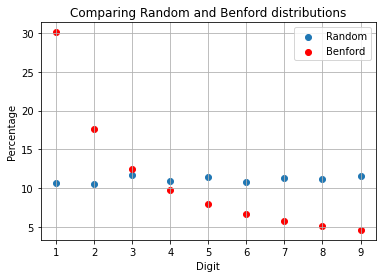

RMSE:  0.31370362893260556 




In [168]:
w = np.random.rand(5674)
Benford_print(w, 'Random')

In [174]:
# let's generate a number of random vectors and see the average RMSE

for k in range(100):
    length = np.random.randint(1,10000)
    perc, RMSE = Benford(np.random.rand(length))
    if k ==0: 
        RMSE_ = RMSE
        perc_ = np.array([perc])
    else:
        RMSE_ = np.append(RMSE_,RMSE)
        perc_ = np.append(perc_,np.array([perc]), axis =0)
    
print('Average RMSE:', RMSE_.mean())
print('Average percentages:', perc_.mean(axis=0))

# should tend to 11.11.. let us increas the numbers

Average RMSE: 0.308924649367839
Average percentages: [11.56688476 10.88640406 11.05136655 11.22276844 11.05633922 11.08561828
 11.10790322 11.19784676 10.82486873]


In [175]:
for k in range(1000):
    length = np.random.randint(1,100000)
    perc, RMSE = Benford(np.random.rand(length))
    if k ==0: 
        RMSE_ = RMSE
        perc_ = np.array([perc])
    else:
        RMSE_ = np.append(RMSE_,RMSE)
        perc_ = np.append(perc_,np.array([perc]), axis =0)
    
print('Average RMSE:', RMSE_.mean())
print('Average percentages:', perc_.mean(axis=0))

# already better :)

Average RMSE: 0.3052821971445936
Average percentages: [11.09381952 11.11075062 11.10910022 11.1077094  11.1247646  11.09184392
 11.12421853 11.14294626 11.09484694]


### The shape of the enford distribution reminds me the exponential one. What's its error?

In [162]:
from scipy.stats import expon
data_expon = expon.rvs(scale=1,loc=0,size=1000)

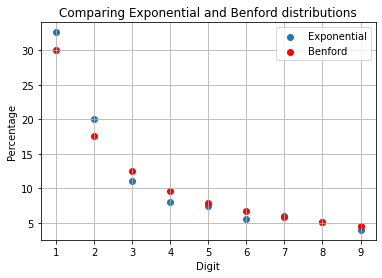

RMSE:  0.056798852241569754 




In [169]:
Benford_print(data_expon, 'Exponential')

In [170]:
# again, let's find an average RMSE

for k in range(1000):
    length = np.random.randint(1,1000)
    perc, RMSE = Benford(expon.rvs(scale=1,loc=0,size=length))
    if k ==0: 
        RMSE_ex = RMSE
        perc_ex = np.array([perc])
    else:
        RMSE_ex = np.append(RMSE_ex,RMSE)
        perc_ex = np.append(perc_ex,np.array([perc]), axis =0)
    
print('Average RMSE:', RMSE_ex.mean())
print('Average percentages:', perc_ex.mean(axis=0))

Average RMSE: 0.08982251005406712
Average percentages: [32.76191072 17.59367064 11.44267021  8.60324616  7.18914407  6.38635789
  5.73155612  5.45752478  4.83391944]


### Now it's time to take some real dataset and see whether Benford's law holds

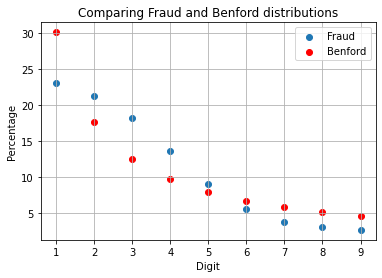

RMSE:  0.14664955548014777 




In [171]:
# we take the Fraud Detection on Bank Payments dataset from 
# https://www.kaggle.com/turkayavci/fraud-detection-on-bank-payments/data

df = pd.read_csv('fraud_detection_bank_dataset.csv')

# and consider the column with the amount of the purchase 
amount = df['amount']
Benford_print(amount, 'Fraud')

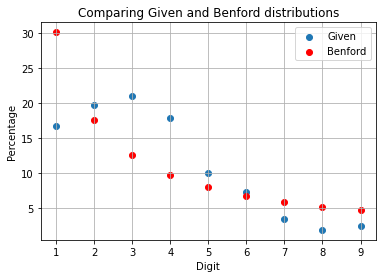

RMSE:  0.2441275146594341 




In [172]:
# Consider the MusicNet dataset, a collection of 330 freely-licensed classical music recordings
# https://www.kaggle.com/imsparsh/musicnet-dataset?select=musicnet_metadata.csv

df_1 = pd.read_csv('musicnet_metadata.csv')

# and consider the column with the duration of the recording, in seconds
sec = df_1['seconds']
Benford_print(sec)

# NOPE... it looks more like a gaussian

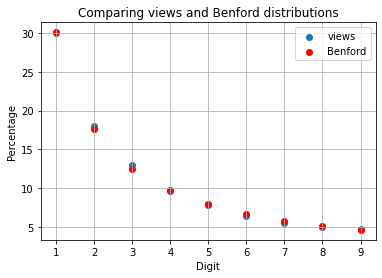

RMSE:  0.00928091004746307 




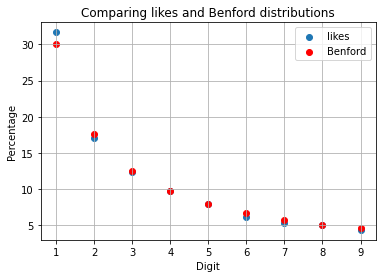

RMSE:  0.023828268477435136 




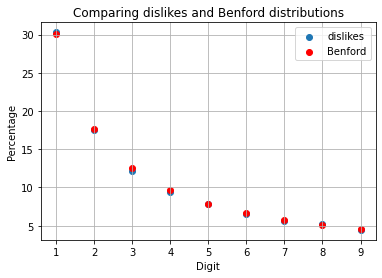

RMSE:  0.0078072070125858066 




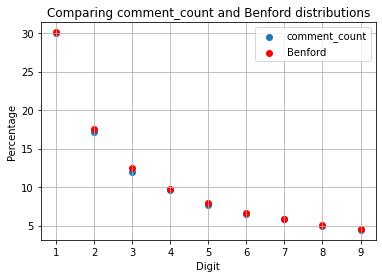

RMSE:  0.010653841084520414 




In [173]:
# Trending YouTube Video Statistics
# https://www.kaggle.com/datasnaek/youtube-new?select=USvideos.csv

dfYT = pd.read_csv('USvideos.csv')

attr = ['views', 'likes', 
        'dislikes', 'comment_count']

dfYT_copy= dfYT.copy()
for col in attr:
    Benford_print(dfYT_copy[col],col)
    
# WOW!! I don't need to explain the results... it fits perfectly :) 
# we could try to study the outliars and see what they have in common

### Let's study in more detail the YouTube dataframe

In [11]:
# missing values?

dfYT.isnull().sum() # only a large amount in the 'description' column has NaN values
dfYT.drop(['description'], axis=1, inplace= True)
dfYT.isnull().sum() 

video_id                  0
trending_date             0
title                     0
channel_title             0
category_id               0
publish_time              0
tags                      0
views                     0
likes                     0
dislikes                  0
comment_count             0
thumbnail_link            0
comments_disabled         0
ratings_disabled          0
video_error_or_removed    0
dtype: int64

In [12]:
# I'm courious about how old are the videos -- I suppose the oldest have more chances to have highest views/likes/etc..

dfYT['publish_time'] = pd.to_datetime(dfYT['publish_time'])
dates = dfYT['publish_time'].copy()
print('Oldest video: ', min(dates))
print('Most recent video: ', max(dates))

Oldest video:  2006-07-23 08:24:11+00:00
Most recent video:  2018-06-14 01:31:53+00:00


In [13]:
# how many days later after the publication a video goes in the trends?

# dfYT['trending_date'] = pd.to_datetime(dfYT['trending_date'])
# it looks the dates have a strange format... convert it to timedate accordingly
dfYT['trending_date'] = pd.to_datetime(dfYT['trending_date'], format = '%y.%d.%m')
# don't consider timezone of the published time, as I don't know the one of the trending date
dfYT['publish_time'] = dfYT['publish_time'].apply(lambda x: x.replace(tzinfo=None))
# calculate the delta
diff = dfYT['trending_date']-dfYT['publish_time']

print ('Minimum time: ', diff.min())
print ('Maximum time: ', diff.max())
print ('Mean time: ', diff.mean())
print ('Median time: ', diff.median())
# mean value and mean are quite different.. the most of the videos are viral in very short time!
dfYT['trending_time'] = diff

Minimum time:  -1 days +10:59:56
Maximum time:  4214 days 15:35:49
Mean time:  16 days 05:21:53.236220664
Median time:  4 days 18:59:55


In [14]:
# erase some useless column
droppable = ['video_id', 
             'tags',
             'thumbnail_link']
dfYT.drop(droppable, axis = 1, inplace= True)

In [87]:
dfYT.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [23]:
dfYT.describe()

,category_id,views,likes,dislikes,comment_count,trending_time
count,40949.000000,4.094900e+04,4.094900e+04,4.094900e+04,4.094900e+04,40949
mean,19.972429,2.360785e+06,7.426670e+04,3.711401e+03,8.446804e+03,16 days 05:21:53.236220664
std,7.568327,7.394114e+06,2.288853e+05,2.902971e+04,3.743049e+04,146 days 00:18:47.135218340
min,1.000000,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00,-1 days +10:59:56
25%,17.000000,2.423290e+05,5.424000e+03,2.020000e+02,6.140000e+02,2 days 10:00:01
50%,24.000000,6.818610e+05,1.809100e+04,6.310000e+02,1.856000e+03,4 days 18:59:55
75%,25.000000,1.823157e+06,5.541700e+04,1.938000e+03,5.755000e+03,8 days 02:04:49
max,43.000000,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06,4214 days 15:35:49


### Benfordness per channel:

In [155]:
dfYT.channel_title.value_counts()

# there are 2207 different channels

ESPN                                      203
The Tonight Show Starring Jimmy Fallon    197
TheEllenShow                              193
Netflix                                   193
Vox                                       193
                                         ... 
yeokm1                                      1
misleadingsilhouette                        1
BillyCrammer                                1
Absolut                                     1
Check It Out                                1
Name: channel_title, Length: 2207, dtype: int64

In [150]:
# create a dictionary with {'channel title': mean squared error, ....}
RMSE_dict = {}

# lets' consider videos with at least 100 videos
n_videos = 100

for channel in dfYT.channel_title.unique():
    if dfYT.channel_title.value_counts()[channel]< n_videos: continue
    df_ch = dfYT[dfYT['channel_title']==channel]
    c, rmse = Benford(df_ch['views'])
    RMSE_dict[channel] = rmse
     

{'Good Mythical Morning': 5.77546612644735,
 'Saturday Night Live': 5.248591647834138,
 'CrazyRussianHacker': 8.879601951261918,
 '20th Century Fox': 8.163876906556386,
 'Vox': 10.079722056992514,
 'NFL': 5.007954793152435,
 'TED-Ed': 7.584616326244788,
 'SciShow': 8.339951117152207,
 'Life Noggin': 7.617701598770997,
 'Tom Scott': 6.527240197960768,
 'HellthyJunkFood': 7.712489193204698,
 'Screen Junkies': 9.842158370557563,
 'FBE': 7.272479697304424,
 'WWE': 4.086308092909254,
 'The Graham Norton Show': 6.309175744696781,
 'Safiya Nygaard': 11.666399783510782,
 'INSIDER': 2.4023110145782747,
 'The Late Late Show with James Corden': 3.3719742466836973,
 'Bon Appétit': 4.69003715220907,
 'ABC News': 4.133468283443657,
 'CinemaSins': 7.961256923549474,
 'IISuperwomanII': 12.757346556257792,
 'Late Night with Seth Meyers': 4.302526113393556,
 'TheEllenShow': 2.7603895151183235,
 'Marques Brownlee': 10.163200236798172,
 'Vogue': 4.47505102011732,
 'The Late Show with Stephen Colbert': 3.2

In [151]:
# Channel with higher error:

ch_max = max(RMSE_dict, key=RMSE_dict.get)
ch_max

'jacksfilms'

VIEWS


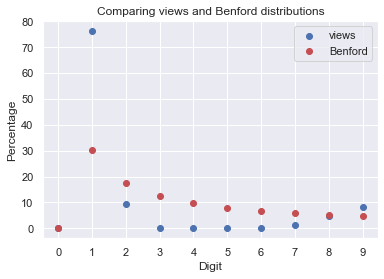

Root mean squared error: 
 16.110028862446768 


LIKES


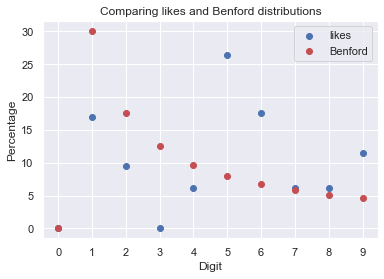

Root mean squared error: 
 9.576485308015588 


DISLIKES


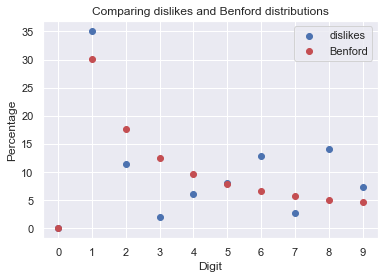

Root mean squared error: 
 5.687293001073396 


COMMENT_COUNT


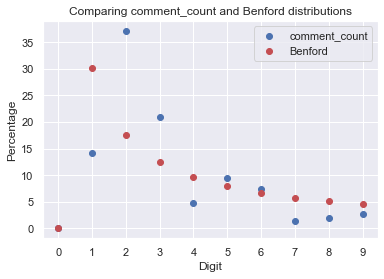

Root mean squared error: 
 8.761686050055493 




In [154]:
for col in attr:
    print(col.upper())
    Benford_print(dfYT[dfYT['channel_title']==ch_max][col],col)

In [156]:
# it looks that there are a high number of views starting with 1... maybe this is the reason

# I'll look at the second highest

# would also like to find a treshold for the RMSE to accept

In [160]:
x = sorted(((v,k) for k,v in RMSE_dict.items()))

ch_sec = x[-2][1]
ch_third = x[-3][1]

Dude Perfect
VIEWS


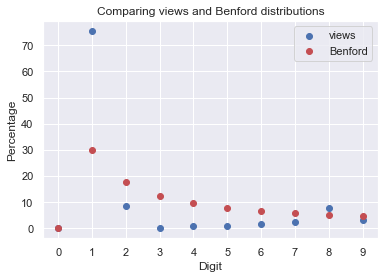

Root mean squared error: 
 15.771444873536034 


LIKES


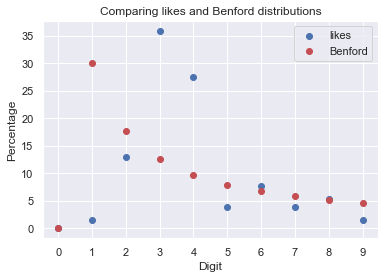

Root mean squared error: 
 13.15853617604822 


DISLIKES


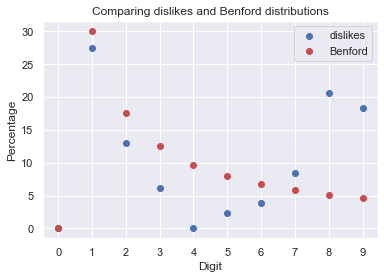

Root mean squared error: 
 7.990980806858412 


COMMENT_COUNT


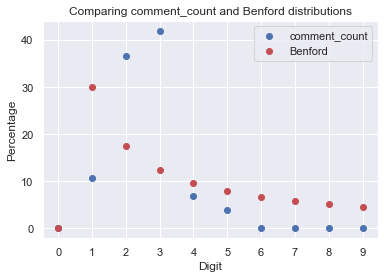

Root mean squared error: 
 13.263338331578506 




In [163]:
print('Channel name: ', ch_sec)
for col in attr:
    print(col.upper())
    Benford_print(dfYT[dfYT['channel_title']==ch_sec][col],col)

Cannel name:  Smosh
VIEWS


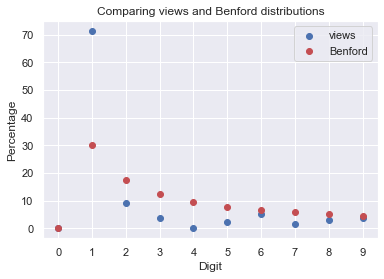

Root mean squared error: 
 14.175956993619355 


LIKES


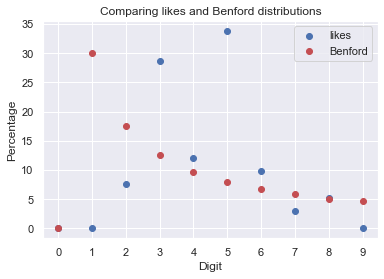

Root mean squared error: 
 14.079773524451971 


DISLIKES


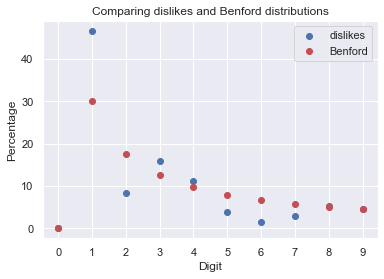

Root mean squared error: 
 6.5201356605213014 


COMMENT_COUNT


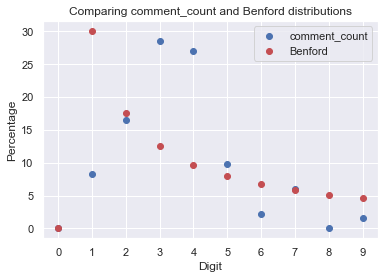

Root mean squared error: 
 10.471273270704687 




In [164]:
print('Cannel name: ', ch_third)

for col in attr:
    print(col.upper())
    Benford_print(dfYT[dfYT['channel_title']==ch_third][col],col)